# Explorative Analysis for the project
***

## Initial Setup

In [1]:
# Importing sklearn, nltk, numpy, pandas and other libararies

%run ../src/import_libraries.py
%matplotlib inline


## Loading custom functions

In [2]:
%run ../src/import_functions.py 

* Helper function **pos_tagger** to map pos_tag and wordnet.  

* Function **get_lemmatized** to clean and replace words with its base/dictionary form.  

* function **bag_of_words** to return a tuple  

(I. frequency dictionaries for each class. II. difference dictionaries for class specific words )

* Function **transform_image** to transform an image for wordcloud mask
* Helper function **transform_format** for **transform_image**

In [3]:
%run ../src/initial_preprocessing.py


Total number or reviews: 568454
Total number of na (nulls): 43

Dropping 43 out of 568454 reviews

-------------------------------------------------------------------------

Original columns:  Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Updated_Score'],
      dtype='object')

Leaving 'Text','Summary' and 'Score' columns:

Selected columns:  Index(['Text', 'Summary', 'Score', 'Updated_Score'], dtype='object')

-------------------------------------------------------------------------



## Initial Exploration

In [4]:
df.head(3)

,Text,Summary,Score,Updated_Score
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,Good Quality Dog Food,5,pos
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised,1,neg
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.","""Delight"" says it all",4,pos


In [5]:
print('\nTotal number of rows: ', len(df))



Total number of rows:  525789


In [6]:
print('Number of unique users: ', len(df_raw['UserId'].unique()))
print('Number of unique products: ', len(df_raw['ProductId'].unique()))

Number of unique users:  256059
Number of unique products:  74258


## Checking Target distribution

In [7]:
# Original target distribution:
print(df_raw["Score"].value_counts(normalize=True).map(lambda x: str(round(x*100,2))+'%').sort_index(ascending=False))

5    63.88%
4    14.19%
3      7.5%
2     5.24%
1     9.19%
Name: Score, dtype: object


In [8]:
# Updated target distribution:
# 1,2 - Negative; 4,5 - Positive
print(df["Updated_Score"].value_counts(normalize=True).map(lambda x: str(round(x*100,2))+'%').sort_index(ascending=False))

pos    84.4%
neg    15.6%
Name: Updated_Score, dtype: object


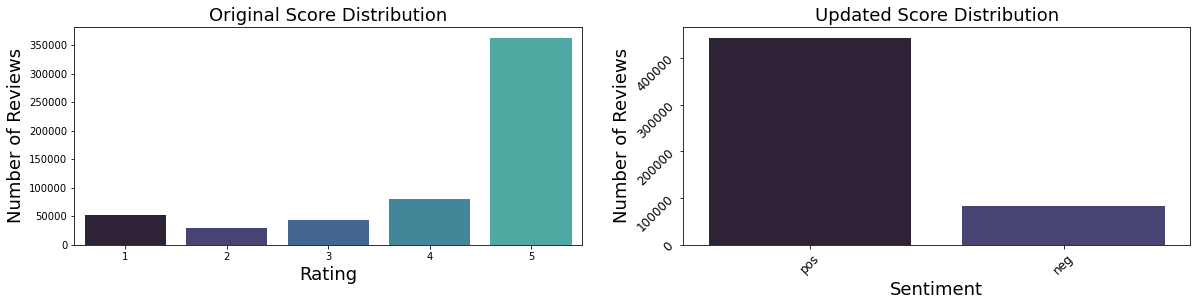

In [9]:
#Exploring targets:
fig, [ax,ax2] = plt.subplots( ncols=2, figsize=(20,4))
sns.set_palette("mako")
sns.barplot(df_raw["Score"].value_counts().index, df_raw["Score"].value_counts(), ax=ax );
sns.barplot(df["Updated_Score"].value_counts().index, df["Updated_Score"].value_counts(), ax=ax2 );
ax.set_title('Original Score Distribution',size=18)
ax2.set_title('Updated Score Distribution',size=18)
ax.set_xlabel('Rating', size=18)
ax2.set_xlabel('Sentiment', size=18)
ax.set_ylabel('Number of Reviews', size=18);
ax2.set_ylabel('Number of Reviews', size=18);
plt.yticks(size=12, rotation=45)
plt.xticks(size=12, rotation=45)

fig.savefig('../images/Number_of_Reviews.jpg')



## Findings

* As classes are not balanced - **ComplementNB** will be the first candidate for an estimator  

# Number of unique of words

In [10]:
# Checking  initial number of unique words:

all_text_words_n=len(set(df['Text'].str.split().explode()))
print("Number of unique words in review body: ", all_text_words_n )


Number of unique words in review body:  553862


## Creating a sample of data to save time on execution:

In [13]:
# Creating a sample of data to save time on execution:
n=5000
df_sample=df.sample(n,random_state=12)

## Checking number of words before and after lemmatization

In [14]:
sample_text_words_n=len(set(df_sample['Text'].str.split().explode()))
print("Number of unique words in sample review body: ", sample_text_words_n )
sample_summary_words_n=len(set(df_sample['Summary'].str.split().explode()))
print("Number of unique words in sample review summary: ",sample_summary_words_n )

Number of unique words in sample review body:  35695
Number of unique words in sample review summary:  5974


In [15]:
lemmatized_sample_text_n=len(set(df_sample['Text'].map(get_lemmatized).explode()))
lemmatized_sample_summary_n=len(set(df_sample['Summary'].map(get_lemmatized).explode()))
print("Number of unique lemmatized words in sample review body: ", lemmatized_sample_text_n )
print("Number of unique lemmatized words in sample review summary: ",lemmatized_sample_summary_n )


Number of unique lemmatized words in sample review body:  4960
Number of unique lemmatized words in sample review summary:  3708


In [16]:
text_perc=round(sample_text_words_n/lemmatized_sample_text_n,1)
summary_perc=round(sample_summary_words_n/lemmatized_sample_summary_n,1)
print(f"Number of unique words in {n} rows sample was reduced {text_perc} times")
print(f"Number of unique words in  {n} rows sample was reduced {summary_perc} times")

Number of unique words in 5000 rows sample was reduced 7.2 times
Number of unique words in  5000 rows sample was reduced 1.6 times


## Checking and visualizing Frequency Distributions

In [17]:
diff_dic, freqdist_dic=bag_of_words(df_sample, 'Updated_Score')



In [18]:
### Function to plot wordcloud based on a freqdist diff_dic dictionary:
## Takes 3 arguments: 1. dictionary 2. word length 3. number of words

def plot_important_words(diff_dic, word_ln, n_words):
    thumbs_down="../images/thumbdown2.png"
    thumbs_up="../images/thumbup2.png"
    fig, ax=plt.subplots(ncols=2, figsize=(18,10))

    for num,image in enumerate([thumbs_up, thumbs_down]):
        param_dic={1:['red','autumn','neg'], 0:['green', None ,'pos']}
        stars=param_dic[num][2]

        freq_dic={}
        for key,value in diff_dic[stars].items():
            if len(key)> word_ln and value < 0.004:
                freq_dic[key]=value

        transformed_thumb=transform_image(image)  

        wc = WordCloud(background_color="black",  collocations=False, max_words=n_words, max_font_size=2000, min_font_size=10, 
                       width=1600, height=400,  mask=transformed_thumb, colormap=param_dic[num][1],
                       contour_width=4, contour_color=param_dic[num][0]).generate_from_frequencies(freq_dic)

        ax[num].imshow(wc, interpolation='bilinear')
        ax[num].axis("off");
        fig.set_tight_layout({'pad':0})
        fig.savefig('../images/key_words.jpg')
        

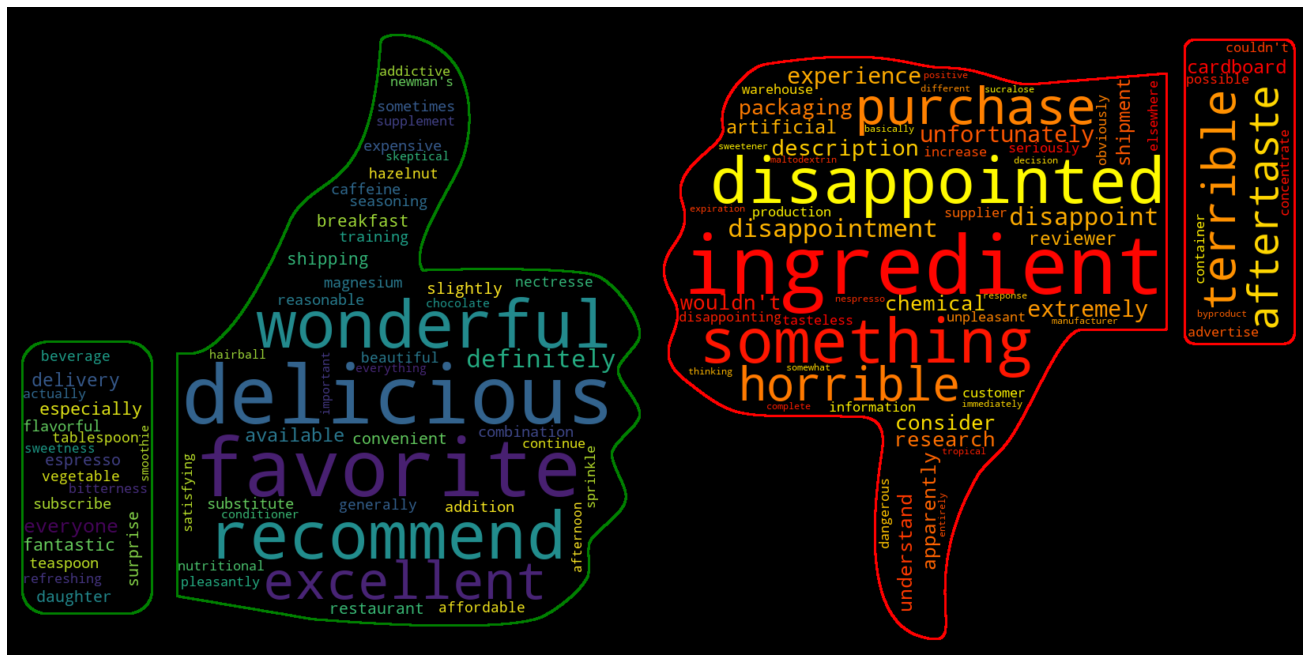

In [19]:
plot_important_words(diff_dic, 7, 60)

## Summary of EDA

The words for each class make perfect sense, hopefully we can build a good model  
The next step - building a model based on bag of words
